In [154]:
import os
import sys
import glob
import yaml
import pickle
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set('talk')
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm
import sys
sys.path.append('../../')
from src.io_f import read_data_file
from src import compute_f
from scipy.signal import butter, lfilter

## config

In [155]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]


In [156]:
EXP_NAME

'exp045'

## read data

In [157]:
# waypointを補正したdataset
root_dir = Path('../../input/')
with open(root_dir/'2kaido_wifi_dataset_v3/train_10000_7.pkl', 'rb') as f:
  train_df = pickle.load(f)

with open(root_dir/'2kaido_wifi_dataset_v3/test_10000_7.pkl', 'rb') as f:
  test_df = pickle.load(f)


In [158]:
train_df = train_df.astype({'timestamp':int,'x': np.float32, 'y': np.float32, 'floor':np.float32, 'ix':np.float32, 'iy':np.float32, 'timediff':np.int})
test_df = test_df.astype({'timestamp':int})
train_df['site_path_timestamp'] = train_df['site_id'] + "_" + train_df['path'] + '_' + train_df['timestamp'].astype(str)

In [159]:
train_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,itimestamp,ix,iy,floor,floor_str,path,site_id,timediff,itimediff,site_path_timestamp
0,356d66c73c423be835bd5d07cb1ebdfa821d8e23,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,4e601619b7c7d9df8d61490ad2c134f08ea01d61,c3513a636d1a813db081a2ffc33f297b4fefe28d,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,3745dc080c9396d2317f4c05d7141c1df83acf9d,...,1578466134278,113.615387,156.634796,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-1545,-45,5a0546857ecc773753327266_5e1580d1f4c3420006d52...
1,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,1578466136278,112.655884,156.358200,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-3512,-12,5a0546857ecc773753327266_5e1580d1f4c3420006d52...
2,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,c3513a636d1a813db081a2ffc33f297b4fefe28d,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,4e601619b7c7d9df8d61490ad2c134f08ea01d61,2ce029b3a3dea973a44bf0587be5e2b93a74e5f1,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,3fa90121039c7b6e24ae985d228e0366ae15fba4,3745dc080c9396d2317f4c05d7141c1df83acf9d,...,1578466138278,111.936256,156.150772,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-5471,29,5a0546857ecc773753327266_5e1580d1f4c3420006d52...
3,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,990847ae755de95a44c7b1be54e66f4e56fdc7f4,da39a3ee5e6b4b0d3255bfef95601890afd80709,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,3fa90121039c7b6e24ae985d228e0366ae15fba4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,1578466140278,110.976761,155.874176,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-7428,72,5a0546857ecc773753327266_5e1580d1f4c3420006d52...
4,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,990847ae755de95a44c7b1be54e66f4e56fdc7f4,c3513a636d1a813db081a2ffc33f297b4fefe28d,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,...,1578466142278,110.017258,155.597580,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,7401,105,5a0546857ecc773753327266_5e1580d1f4c3420006d52...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252807,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,18336f0964fbd470a2ee7116d33b96946c633999,040667e2fdd3a9bbb54e970c430ad6f08416c52e,072159287058774aa9b450c9163129b309bc982b,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,90ef6526fa145d95dc065edc3b3a3193406f3ee4,...,1573892866000,128.925217,109.018059,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,-2224,38,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...
252808,18336f0964fbd470a2ee7116d33b96946c633999,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,072159287058774aa9b450c9163129b309bc982b,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,040667e2fdd3a9bbb54e970c430ad6f08416c52e,da39a3ee5e6b4b0d3255bfef95601890afd80709,ea9e102c49dbc834b1059c5e8b5dc4a017a82d

In [160]:
df = train_df.groupby('site_path_timestamp')[['x', 'y']].mean().reset_index()
df['site'] = df['site_path_timestamp'].str.split("_", expand=True)[0]
df['path'] = df['site_path_timestamp'].str.split("_", expand=True)[1]
df['timestamp'] = df['site_path_timestamp'].str.split("_", expand=True)[2]
df = df.merge(train_df[['site_path_timestamp', 'floor_str']].drop_duplicates(), on='site_path_timestamp')
df

,site_path_timestamp,x,y,site,path,timestamp,floor_str
0,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,78.218193,38.999737,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368762838,F3
1,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,76.251839,30.510839,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,F3
2,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,78.364815,10.530369,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368793535,F3
3,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,79.231522,7.736414,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368798851,F3
4,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,90.919060,13.197551,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368814782,F3
...,...,...,...,...,...,...,...
71221,5dc8cea7659e181adb076a3f_5dd7c1189191710006b56...,204.210922,106.165436,5dc8cea7659e181adb076a3f,5dd7c1189191710006b568d0,1574420722415,B1
71222,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,204.210922,106.165436,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420726383,B1
71223,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,195.152832,109.600800,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420736142,B1
71224,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,193.204880,108.001518,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420742502,B1


In [147]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [148]:
def calc_rel_positions(path_df):   
    site = path_df['site'].unique()[0]
    floor = path_df['floor_str'].unique()[0]
    path = path_df['path'].unique()[0]
    
    T_ref  = path_df['timestamp'].astype(int).values
    xy_hat = path_df[['x', 'y']].values

    INPUT_PATH = '../../input/indoor-location-navigation'
    example = read_data_file(f'{INPUT_PATH}/train/{site}/{floor}/{path}.txt')
    rel_positions = compute_rel_positions(example.acce, example.ahrs)

    # deltaの最初にはゼロが入る
    if T_ref[-1] > rel_positions[-1, 0]:  # deltaの最後のtimestampよりwaypointのtimestampが多い場合最後は０埋め
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)

    T_rel = rel_positions[:, 0]  # deltaのtimestamp
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    delta = np.concatenate([np.array([[0, 0]]), delta_xy_hat])  # 00はstart地点
    path_df['sensor_delta_x'] = delta[:, 0]
    path_df['sensor_delta_y'] = delta[:, 1]
    return path_df

In [90]:
dfs = []
for path, path_df in tqdm(df.groupby('path')):
    path_df = calc_rel_positions(path_df)
    dfs.append(path_df)
delta_df = pd.concat(dfs)

100%|██████████| 10826/10826 [46:48<00:00,  3.85it/s] 


In [91]:
delta_df

,site_path_timestamp,x,y,site,path,timestamp,floor_str,sensor_delta_x,sensor_delta_y
2461,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,198.052063,93.971237,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,1560500995805,F3,0.000000,0.000000
2462,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,180.073349,89.948959,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,1560501011427,F3,-13.370739,-3.282570
2463,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,180.073349,89.948959,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501353313,F3,0.000000,0.000000
2464,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,181.347610,84.303024,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501359897,F3,0.767796,-4.280302
2465,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,179.019287,79.741631,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501366899,F3,-1.526216,-3.978836
...,...,...,...,...,...,...,...,...,...
2456,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,49.308346,187.129456,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,1578483574917,B1,-5.043760,2.864301
2457,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,42.038811,188.210541,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,1578483580134,B1,-4.470878,2.854939
2458,5a0546857ecc773753327266_5e15bf941506f2000638f...,107.938766,148.184357,5a0546857ecc773753327266,5e15bf941506f2000638fec5,1578483469045,B1,0.000000,0.000000
2459,5a0546857ecc773753327266_5e15bf941506f2000638f...,106.659012,154.629517,5a0546857ecc773753327266,5e15bf941506f2000638fec5,1578483477240,B1,-1.699576,4.860221


In [96]:
dfs2 = []
for path, path_df in tqdm(delta_df.groupby('path')):
    path_df['delta_x'] = path_df['x'] - path_df['x'].shift(1)
    path_df['delta_y'] = path_df['y'] - path_df['y'].shift(1)
    dfs2.append(path_df)
delta_df2 = pd.concat(dfs2)

100%|██████████| 10826/10826 [00:08<00:00, 1203.44it/s]


In [99]:
delta_df2 = delta_df2.fillna(0)
delta_df2

,site_path_timestamp,x,y,site,path,timestamp,floor_str,sensor_delta_x,sensor_delta_y,delta_x,delta_y
2461,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,198.052063,93.971237,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,1560500995805,F3,0.000000,0.000000,0.000000,0.000000
2462,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,180.073349,89.948959,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,1560501011427,F3,-13.370739,-3.282570,-17.978714,-4.022278
2463,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,180.073349,89.948959,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501353313,F3,0.000000,0.000000,0.000000,0.000000
2464,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,181.347610,84.303024,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501359897,F3,0.767796,-4.280302,1.274261,-5.645935
2465,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,179.019287,79.741631,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501366899,F3,-1.526216,-3.978836,-2.328323,-4.561394
...,...,...,...,...,...,...,...,...,...,...,...
2456,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,49.308346,187.129456,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,1578483574917,B1,-5.043760,2.864301,-5.835197,1.488266
2457,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,42.038811,188.210541,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,1578483580134,B1,-4.470878,2.854939,-7.269535,1.081085
2458,5a0546857ecc773753327266_5e15bf941506f2000638f...,107.938766,148.184357,5a0546857ecc773753327266,5e15bf941506f2000638fec5,1578483469045,B1,0.000000,0.000000,0.000000,0.000000
2459,5a0546857ecc773753327266_5e15bf941506f2000638f...,106.659012,154.629517,5a0546857ecc773753327266,5e15bf941506f2000638fec5,1578483477240,B1,-1.699576,4.860221,-1.279755,6.445160


In [100]:
delta_df2.to_csv('delta.csv', index=False)

## deltaの(error)を計算

In [149]:
delta = pd.read_csv("delta.csv")
delta

,site_path_timestamp,x,y,site,path,timestamp,floor_str,sensor_delta_x,sensor_delta_y,delta_x,delta_y
0,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,198.052060,93.971240,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,1560500995805,F3,0.000000,0.000000,0.000000,0.000000
1,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,180.073350,89.948960,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,1560501011427,F3,-13.370739,-3.282570,-17.978714,-4.022278
2,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,180.073350,89.948960,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501353313,F3,0.000000,0.000000,0.000000,0.000000
3,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,181.347610,84.303024,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501359897,F3,0.767796,-4.280302,1.274261,-5.645935
4,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,179.019290,79.741630,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501366899,F3,-1.526216,-3.978836,-2.328323,-4.561394
...,...,...,...,...,...,...,...,...,...,...,...
71221,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,49.308346,187.129460,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,1578483574917,B1,-5.043760,2.864301,-5.835197,1.488266
71222,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,42.038810,188.210540,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,1578483580134,B1,-4.470878,2.854939,-7.269535,1.081085
71223,5a0546857ecc773753327266_5e15bf941506f2000638f...,107.938770,148.184360,5a0546857ecc773753327266,5e15bf941506f2000638fec5,1578483469045,B1,0.000000,0.000000,0.000000,0.000000
71224,5a0546857ecc773753327266_5e15bf941506f2000638f...,106.659010,154.629520,5a0546857ecc773753327266,5e15bf941506f2000638fec5,1578483477240,B1,-1.699576,4.860221,-1.279755,6.445160


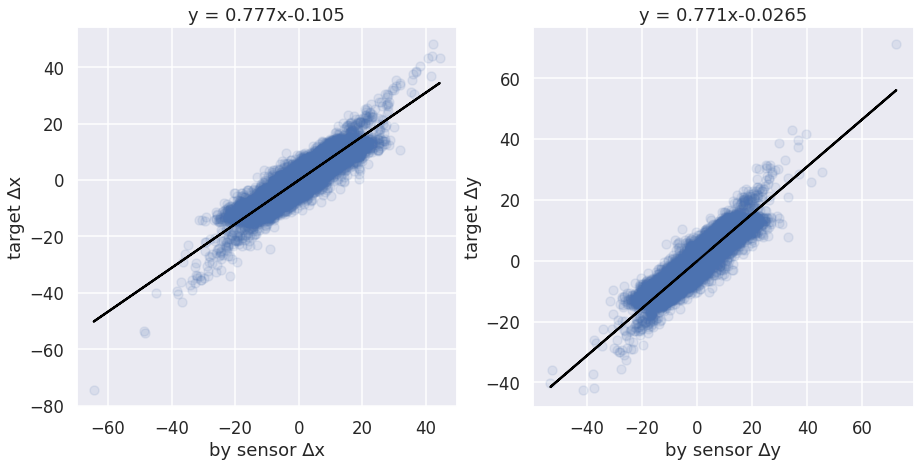

In [126]:
from sklearn import linear_model

target_x = delta["delta_x"].values.reshape(-1,1)
pred_x = delta["sensor_delta_x"].values.reshape(-1,1)
target_y = delta["delta_y"].values.reshape(-1,1)
pred_y = delta["sensor_delta_y"].values.reshape(-1,1)

reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax1.plot(pred_x, reg1.predict(pred_x), color='black')
ax1.scatter(pred_x, target_x, alpha=0.1)
ax1.set_xlabel('by sensor ∆x')
ax1.set_ylabel('target ∆x')
ax1.set_title('y = {:.3g}x{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))

reg2 = linear_model.LinearRegression()
reg2.fit(pred_y, target_y)
ax2 = fig.add_subplot(122)
ax2.plot(pred_y, reg1.predict(pred_y), color='black')
ax2.scatter(pred_y, target_y, alpha=0.1)
ax2.set_xlabel('by sensor ∆y')
ax2.set_ylabel('target ∆y')
ax2.set_title('y = {:.3g}x{:.3g}'.format(reg2.coef_[0][0], reg2.intercept_[0]))
plt.savefig("delta_all.png")

## siteごとに上の可視化を行なってみる。

In [129]:
site_list = delta['site'].unique()

array(['5c3c44b80379370013e0fd2b', '5a0546857ecc773753327266',
       '5d2709a003f801723c3251bf', '5da1382d4db8ce0c98bbe92e',
       '5da138314db8ce0c98bbf3a0', '5d27075f03f801723c2e360f',
       '5d2709b303f801723c327472', '5da138764db8ce0c98bcaa46',
       '5da958dd46f8266d0737457b', '5d2709c303f801723c3299ee',
       '5da138364db8ce0c98bc00f1', '5d27096c03f801723c31e5e0',
       '5da138b74db8ce0c98bd4774', '5d27099f03f801723c32511d',
       '5da1389e4db8ce0c98bd0547', '5da138274db8ce0c98bbd3d2',
       '5d2709d403f801723c32bd39', '5d2709e003f801723c32d896',
       '5d2709bb03f801723c32852c', '5dc8cea7659e181adb076a3f',
       '5da138754db8ce0c98bca82f', '5d27097f03f801723c320d97',
       '5da1383b4db8ce0c98bc11ab', '5dbc1d84c1eb61796cf7c010'],
      dtype=object)

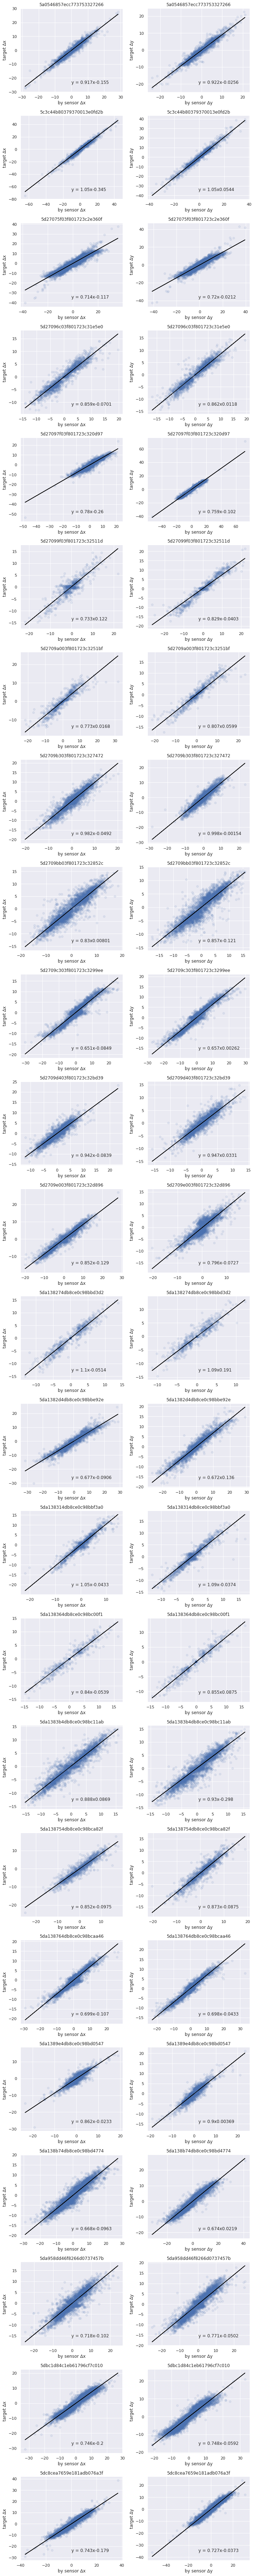

In [150]:
from sklearn import linear_model
delta_x_dict = {}
delta_y_dict = {}
fig = plt.figure(figsize=(10, 100))
sns.set('notebook')
for i, (site, df) in enumerate(delta.groupby('site')):
    target_x = df["delta_x"].values.reshape(-1,1)
    pred_x = df["sensor_delta_x"].values.reshape(-1,1)
    target_y = df["delta_y"].values.reshape(-1,1)
    pred_y = df["sensor_delta_y"].values.reshape(-1,1)
    
    # x
    reg1 = linear_model.LinearRegression()
    reg1.fit(pred_x, target_x)

    ax = fig.add_subplot(24, 2, 2*(i+1)-1)
    ax.plot(pred_x, reg1.predict(pred_x), color='black')
    ax.scatter(pred_x, target_x, alpha=0.1)
    ax.set_xlabel('by sensor ∆x')
    ax.set_ylabel('target ∆x')
    plt.text(0.5,0.1, 'y = {:.3g}x{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]),transform=ax.transAxes)
    ax.set_title('{}'.format(site))
    delta_x_dict[site] = round(reg1.coef_[0][0], 3)
    
    # y
    reg2 = linear_model.LinearRegression()
    reg2.fit(pred_y, target_y)
    ax = fig.add_subplot(24,2,2*(i+1))
    ax.plot(pred_y, reg1.predict(pred_y), color='black')
    ax.scatter(pred_y, target_y, alpha=0.1)
    ax.set_xlabel('by sensor ∆y')
    ax.set_ylabel('target ∆y')
    plt.text(0.5,0.1, 'y = {:.3g}x{:.3g}'.format(reg2.coef_[0][0], reg2.intercept_[0]),transform=ax.transAxes)
    ax.set_title('{}'.format(site))
    delta_y_dict[site] = round(reg2.coef_[0][0], 3)
plt.tight_layout()
plt.savefig("delta_site.png")

In [152]:
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [153]:
pickle_dump(delta_x_dict, 'delta_x_coeff.pkl')
pickle_dump(delta_y_dict, 'delta_y_coeff.pkl')